# Importing Libraries

In [283]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Analysis of Target Column 'GDP' Before Supervised Learning

### Checking for Stationarity

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(economic_data['Gross Domestic Product'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")


ADF Statistic: 8.099528374671129
p-value: 1.0
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
The series is likely non-stationary.


### Trend-Seaonality Analysis

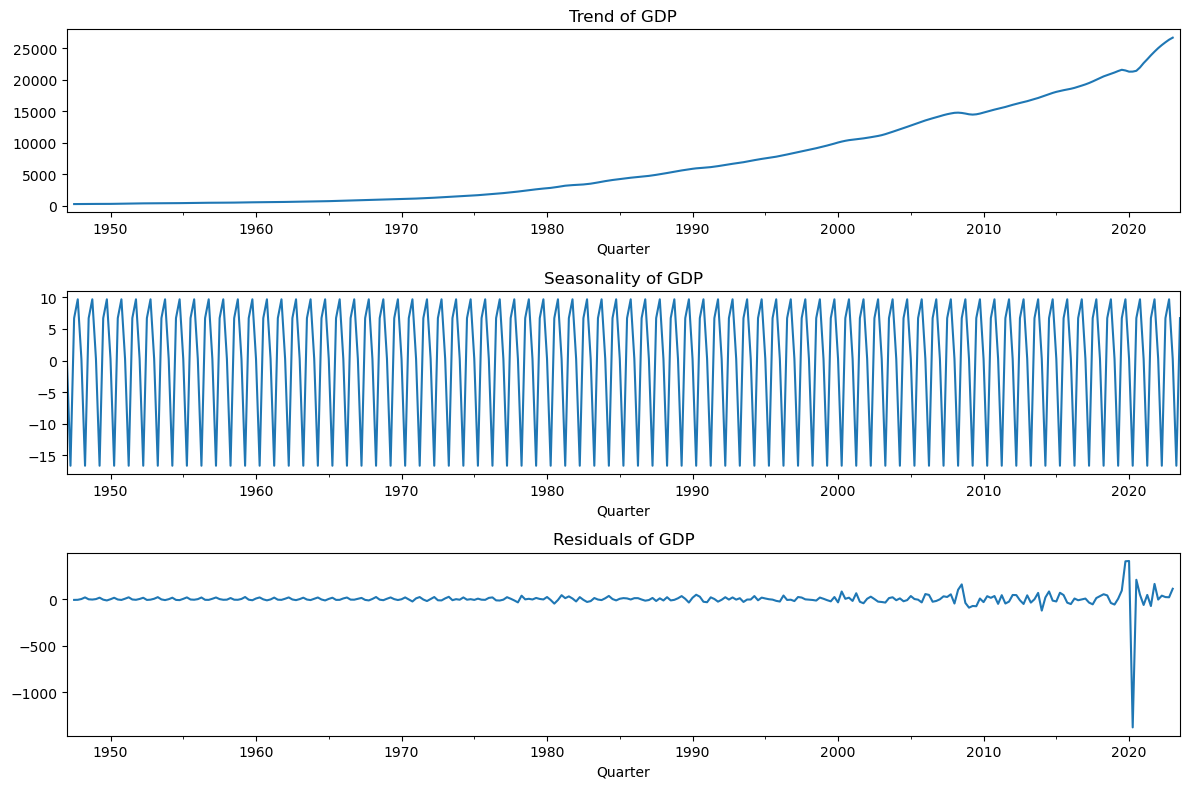

In [27]:

economic_data.index = pd.to_datetime(economic_data.index)
decomposition = sm.tsa.seasonal_decompose(economic_data['Gross Domestic Product'].dropna(), model='additive', period=4)
# Plotting the decomposed time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend of GDP')
decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality of GDP')
decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals of GDP')
plt.tight_layout()
plt.show()

## LSTM Model

In [45]:
import sys
sys.path.append('../src')

from data_management import load_data, preprocess_data, train_data_split
from model_training import define_model_lstm, train_model, define_model_gru, set_random_seed,define_model_cnn
from model_evaluation import score_model, grid_search, pred_test, actual_predict_plot, war_no_war_plot

import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import itertools
n_future = 1
n_past = 16 
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled, _ = preprocess_data(economic_war_data)
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)

train_size =  261
test_size =  29
train_size =  (261, 16, 12)
test_size =  (29, 16, 12)


#### Hyperparameter Tuning On Number_nodes and Batch_size

In [ ]:
param_grid = {
    'num_nodes': [8, 16, 32, 64],
    'batch_size': [1, 4, 8],
    'activation':['relu'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform'],
    'optimizer':['Adam'],
    'learning_rate': [0.01]
}

list_of_trained_model=grid_search(param_grid,X_train,y_train,model_type='LSTM')

In [23]:
print(list_of_trained_model[0].params)

{'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}


In [16]:
for i in range(len(list_of_trained_model)):
    print(list_of_trained_model[i].params)


{'num_nodes': 8, 'batch_size': 1, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 8, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 8, 'batch_size': 8, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 16, 'batch_size': 1, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 16, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 16, 'batch_size': 8, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 32, 'batch_size': 1, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'opt

In [17]:
for i in range(len(list_of_trained_model)):
    print('model=', list_of_trained_model[i].model,'loss=', list_of_trained_model[i].loss)


model= <keras.engine.sequential.Sequential object at 0x156448940> loss= 0.030004968866705894
model= <keras.engine.sequential.Sequential object at 0x15646d790> loss= 0.03506596386432648
model= <keras.engine.sequential.Sequential object at 0x157a5ea00> loss= 0.024365095421671867
model= <keras.engine.sequential.Sequential object at 0x159bb8160> loss= 0.037851352244615555
model= <keras.engine.sequential.Sequential object at 0x15a3646a0> loss= 0.022373249754309654
model= <keras.engine.sequential.Sequential object at 0x15a3fdf10> loss= 0.026699723675847054
model= <keras.engine.sequential.Sequential object at 0x15c399fd0> loss= 0.04947252571582794
model= <keras.engine.sequential.Sequential object at 0x15e5a7040> loss= 0.0237004142254591
model= <keras.engine.sequential.Sequential object at 0x15e54d7c0> loss= 0.024470064789056778
model= <keras.engine.sequential.Sequential object at 0x1699cb700> loss= 0.048846855759620667
model= <keras.engine.sequential.Sequential object at 0x15f66c880> loss= 0.

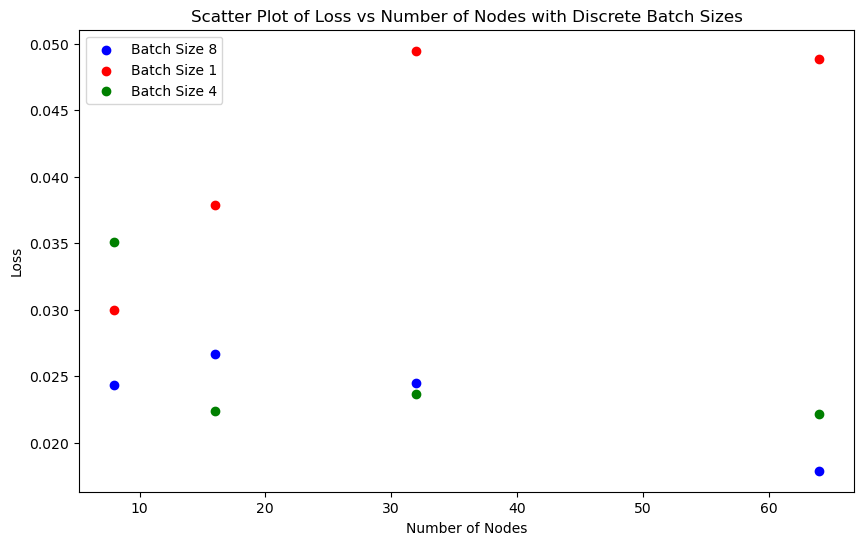

In [18]:
import matplotlib.pyplot as plt

batch_size = []
num_nodes = []
loss = []

for i in range(len(list_of_trained_model)):
    batch_size.append(list_of_trained_model[i].params['batch_size'])
    num_nodes.append(list_of_trained_model[i].params['num_nodes'])
    loss.append(list_of_trained_model[i].loss)

color_map = {1: 'red', 4: 'green', 8: 'blue'}

plt.figure(figsize=(10, 6))

for batch in set(batch_size):
    idx = [i for i, b in enumerate(batch_size) if b == batch]
    plt.scatter([num_nodes[i] for i in idx], [loss[i] for i in idx], color=color_map[batch], label=f'Batch Size {batch}')

plt.xlabel('Number of Nodes')
plt.ylabel('Loss')
plt.title('Scatter Plot of Loss vs Number of Nodes with Discrete Batch Sizes')
plt.legend()
plt.show()


### Hyperparameter Tuning On Learning Rate and Optimizer

In [ ]:
param_grid = {
    'num_nodes': [32],
    'batch_size': [4],
    'activation':['relu'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform'],
    'optimizer': ['SGD', 'Adam'],
    'learning_rate': [0.0001, 0.001, 0.01]
}

list_of_trained_model=grid_search(param_grid,X_train,y_train,model_type='LSTM')

In [20]:
for i in range(len(list_of_trained_model)):
    print('loss=', list_of_trained_model[i].loss,'params=',list_of_trained_model[i].params)

loss= 0.14927631616592407 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'SGD', 'learning_rate': 0.0001}
loss= 0.028161054477095604 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'SGD', 'learning_rate': 0.001}
loss= 0.019184434786438942 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'SGD', 'learning_rate': 0.01}
loss= 0.024637287482619286 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.0001}
loss= 0.014980532228946686 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.02922130562365055 params= {'num_nodes': 32, 'batch_size': 4, 'activati

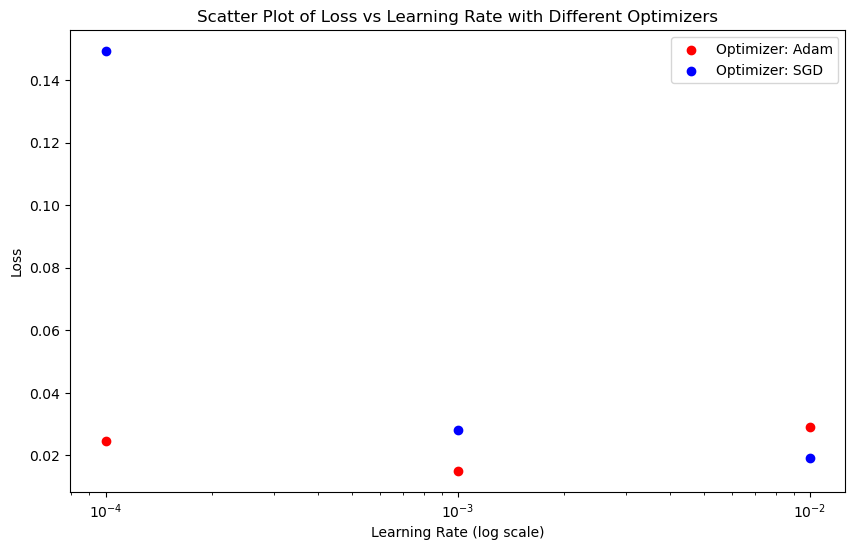

In [21]:
import matplotlib.pyplot as plt
import numpy as np
loss = []
learning_rates = []
optimizers = []

for model in list_of_trained_model:
    loss.append(model.loss)
    learning_rates.append(model.params['learning_rate'])
    optimizers.append(model.params['optimizer'])

loss = np.array(loss)
learning_rates = np.array(learning_rates)
optimizers = np.array(optimizers)

color_map = {'SGD': 'blue', 'Adam': 'red'}

plt.figure(figsize=(10, 6))
for optimizer in np.unique(optimizers):
    idx = optimizers == optimizer
    plt.scatter(learning_rates[idx],loss[idx],color=color_map[optimizer], label=f'Optimizer: {optimizer}')

plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Scatter Plot of Loss vs Learning Rate with Different Optimizers')
plt.legend()
plt.show()



### Hyperparameter Tuning On Dropout, activation and weight initialization

In [ ]:
param_grid = {
    'num_nodes': [32],
    'batch_size': [4],
    'activation':['relu', 'tanh', 'sigmoid'],
    'drop_out': [0.1, 0.2, 0.6, 0.8],
    'init_mode': ['glorot_uniform', 'uniform', 'normal', 'glorot_normal'],
    'optimizer': ['Adam'],
    'learning_rate': [0.001]
}

list_of_trained_model=grid_search(param_grid,X_train,y_train,model_type='LSTM')

In [24]:
for i in range(len(list_of_trained_model)):
    print('loss=', list_of_trained_model[i].loss,'params=',list_of_trained_model[i].params)

loss= 0.019552411511540413 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.011197315528988838 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.01848161593079567 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'normal', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.014531927183270454 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_normal', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.015217200852930546 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.2, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.012633544392883778 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 

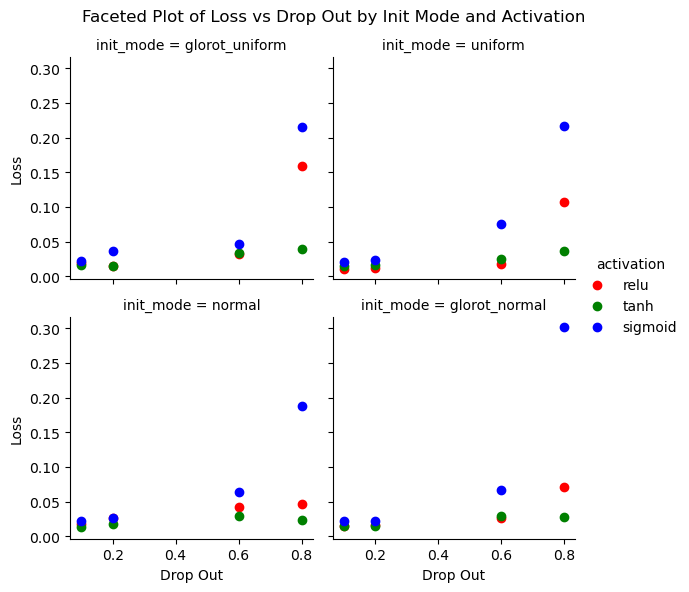

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

data = []
for model in list_of_trained_model:
    data.append({
        'loss': model.loss,
        'drop_out': model.params['drop_out'],
        'init_mode': model.params['init_mode'],
        'activation': model.params['activation']
    })

df = pd.DataFrame(data)
color_map = {'relu': 'red', 'tanh': 'green', 'sigmoid': 'blue'}
g = sns.FacetGrid(df, col="init_mode", hue='activation', palette=color_map, col_wrap=2)
g.map(plt.scatter, 'drop_out', 'loss')
g.add_legend()
g.set_axis_labels("Drop Out", "Loss")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Faceted Plot of Loss vs Drop Out by Init Mode and Activation')

plt.show()


### HyperParameter Tunning On Epoch

In [ ]:
param_grid = {
    'num_nodes': 32,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
window=16
features=12
n_future = 1
n_past = window  
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled = preprocess_data(economic_war_data)
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
num_nodes=param_grid['num_nodes']
learning_rate=param_grid['learning_rate']
drop_out=param_grid['drop_out']
init_mode=param_grid['init_mode']
activation=param_grid['activation']
optimizer=param_grid['optimizer']
n_batch=param_grid['batch_size']
final_chosen_model=define_model_lstm(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer,window,features)
final_trained_model = train_model(final_chosen_model, X_train, y_train,n_batch,epochs=100)

In [29]:
final_trained_model.history['loss']

[0.19292987883090973,
 0.01831016130745411,
 0.01329119224101305,
 0.015644265338778496,
 0.013100224547088146,
 0.00887733418494463,
 0.01094870362430811,
 0.008222279138863087,
 0.00931114237755537,
 0.01049627736210823,
 0.007644888944923878,
 0.006325678434222937,
 0.005989568307995796,
 0.008627885952591896,
 0.006941049359738827,
 0.006083618383854628,
 0.0072986106388270855,
 0.00541237136349082,
 0.006433108355849981,
 0.005563740618526936,
 0.005082225427031517,
 0.0057228379882872105,
 0.004745970945805311,
 0.004386703483760357,
 0.004613734781742096,
 0.003203586209565401,
 0.004798206500709057,
 0.004115704912692308,
 0.0043509225361049175,
 0.004789595026522875,
 0.004058748483657837,
 0.004963901825249195,
 0.00438943924382329,
 0.003743469947949052,
 0.0038080187514424324,
 0.003226206637918949,
 0.0034559518098831177,
 0.004663559142500162,
 0.0033511100336909294,
 0.0029813561122864485,
 0.004042956046760082,
 0.0037937606684863567,
 0.004763311706483364,
 0.004473681

In [30]:
lstm_train_df = pd.DataFrame({
    'LSTM_TRAIN_MSE': final_trained_model.history['loss'],
    'LSTM_TRAIN_RMSE': final_trained_model.history['root_mean_squared_error']
})

lstm_val_df = pd.DataFrame({
    'LSTM_VAL_MSE': final_trained_model.history['val_loss'],
    'LSTM_VAL_RMSE': final_trained_model.history['val_root_mean_squared_error']
})
concatenated_df = pd.concat([lstm_train_df, lstm_val_df], axis=1)
concatenated_df['epoch'] = range(0, len(concatenated_df))
concatenated_df

,LSTM_TRAIN_MSE,LSTM_TRAIN_RMSE,LSTM_VAL_MSE,LSTM_VAL_RMSE,epoch
0,0.192930,0.439238,0.020167,0.142011,0
1,0.018310,0.135315,0.003885,0.062331,1
2,0.013291,0.115287,0.003238,0.056901,2
3,0.015644,0.125077,0.013026,0.114129,3
4,0.013100,0.114456,0.006939,0.083303,4
...,...,...,...,...,...
95,0.003208,0.056640,0.002588,0.050874,95
96,0.002822,0.053120,0.001414,0.037604,96
97,0.002785,0.052777,0.000786,0.028033,97
98,0.003791,0.061575,0.001589,0.039857,98


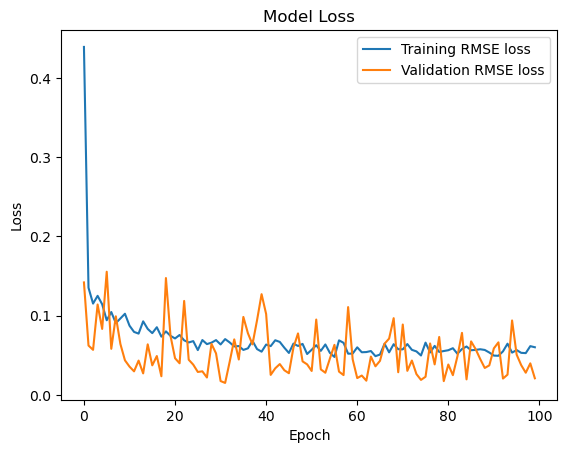

In [31]:
plt.plot(concatenated_df['epoch'], concatenated_df['LSTM_TRAIN_RMSE'], label='Training RMSE loss')
plt.plot(concatenated_df['epoch'], concatenated_df['LSTM_VAL_RMSE'], label='Validation RMSE loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc='upper right')
plt.show()


### Hyperparameter Tuning On Input Sequence Window Size

In [ ]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
windows=[8,12,16,20,24,28]
features=12
n_future = 1
rmse_scores = {}
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled = preprocess_data(economic_war_data)
for window in windows:
    n_past=window
    (X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
    num_nodes=param_grid['num_nodes']
    learning_rate=param_grid['learning_rate']
    drop_out=param_grid['drop_out']
    init_mode=param_grid['init_mode']
    activation=param_grid['activation']
    optimizer=param_grid['optimizer']
    n_batch=param_grid['batch_size']
    model_gru=define_model_gru(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, features = features,window=window)
    trained_model_gru = train_model(model_gru, X_train, y_train, n_batch, epochs=28)
    rmse_scores[window] = min(trained_model_gru.history['val_root_mean_squared_error'])
input_size_df=pd.DataFrame(list(rmse_scores.items()), columns=['Window_Size', 'RMSE']) 

In [104]:
input_size_df.sort_values(by='RMSE')

,Window_Size,RMSE
3,20,0.018199
4,24,0.019726
0,8,0.022037
5,28,0.022372
2,16,0.023722
1,12,0.026215


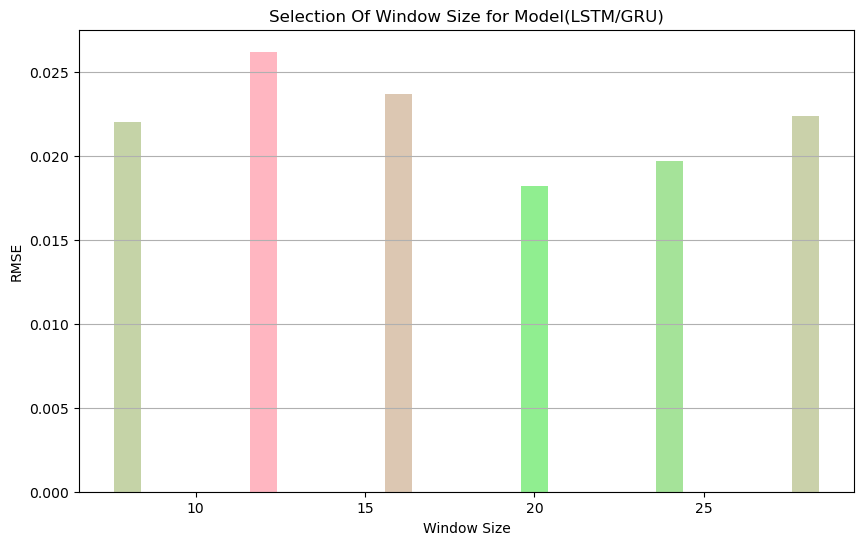

In [135]:
df_sorted = input_size_df.sort_values(by="RMSE")
def interpolate_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    light_green = np.array([144, 238, 144]) / 255.0
    light_red = np.array([255, 182, 193]) / 255.0
    color = light_green * (1 - normalized) + light_red * normalized

    return color

min_rmse = df_sorted['RMSE'].min()
max_rmse = df_sorted['RMSE'].max()
colors = [interpolate_color(value, min_rmse, max_rmse) for value in df_sorted['RMSE']]
plt.figure(figsize=(10, 6))
plt.bar(df_sorted["Window_Size"], df_sorted["RMSE"], color=colors)
plt.title("Selection Of Window Size for Model(LSTM/GRU)")
plt.xlabel("Window Size")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()

## 1D CNN

### Define Param Grid For CNN

param_grid = {
    'num_nodes': [8, 16, 24, 32],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [1, 4],
    'activation': ['relu', 'tanh'],
    'drop_out': [0.1, 0.2, 0.6, 0.8],
    'init_mode': ['glorot_uniform',  'glorot_normal'],
   'optimizer': ['SGD', 'Adam'],
   'kernel_size':[2,3,5]

 }

### Hyperparameter Tuning on Number Of nodes vs batch_size

In [ ]:
param_grid = {
    'num_nodes': [8, 16, 24,32],
    'batch_size': [1, 4],
    'activation':['relu'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform'],
    'optimizer':['Adam'],
    'learning_rate': [0.01],
    'kernel_size':[3]
}

list_of_trained_model_cnn=grid_search(param_grid,X_train,y_train,model_type='CNN')

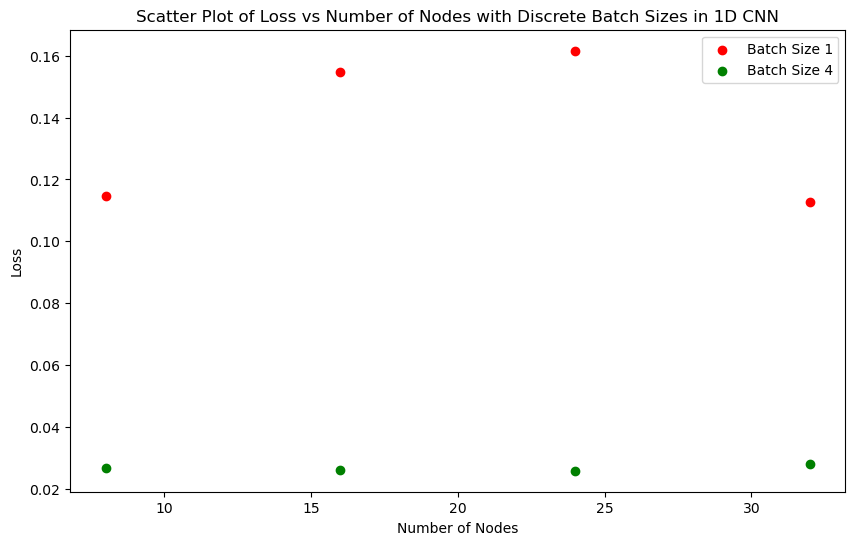

In [47]:
import matplotlib.pyplot as plt

batch_size = []
num_nodes = []
loss = []

for i in range(len(list_of_trained_model_cnn)):
    batch_size.append(list_of_trained_model_cnn[i].params['batch_size'])
    num_nodes.append(list_of_trained_model_cnn[i].params['num_nodes'])
    loss.append(list_of_trained_model_cnn[i].loss)

color_map = {1: 'red', 4: 'green'}
plt.figure(figsize=(10, 6))

for batch in set(batch_size):
    idx = [i for i, b in enumerate(batch_size) if b == batch]
    plt.scatter([num_nodes[i] for i in idx], [loss[i] for i in idx], color=color_map[batch], label=f'Batch Size {batch}')

plt.xlabel('Number of Nodes')
plt.ylabel('Loss')
plt.title('Scatter Plot of Loss vs Number of Nodes with Discrete Batch Sizes in 1D CNN')
plt.legend()
plt.show()

### Hyperparameter Tuning on learning_rate vs optimizer vs activation

In [ ]:
param_grid = {
    'num_nodes': [24],
    'batch_size': [4],
    'activation':['relu','tanh'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform',],
    'optimizer':['Adam','SGD'],
    'learning_rate': [0.0001, 0.001, 0.01],
    'kernel_size':[3]
}

list_of_trained_model_cnn=grid_search(param_grid,X_train,y_train,model_type='CNN')

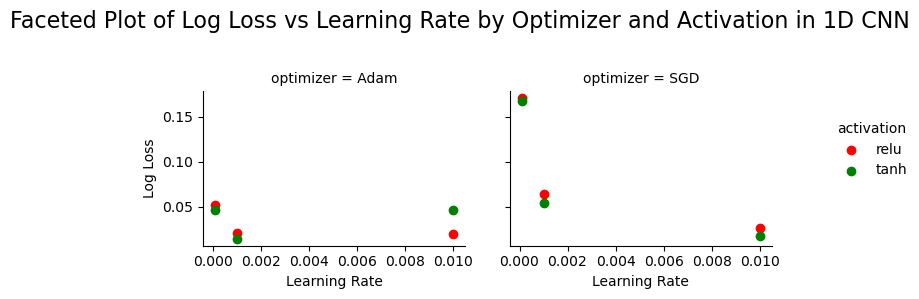

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = []
for model in list_of_trained_model_cnn:
    log_loss = model.loss 
    learning_rate = model.params['learning_rate'] 
    data.append({
        'loss': log_loss,
        'learning_rate': learning_rate, 
        'optimizer': model.params['optimizer'],
        'activation': model.params['activation']
    })

df = pd.DataFrame(data)

color_map = {'relu': 'red', 'tanh': 'green'}

g = sns.FacetGrid(df, col="optimizer", hue='activation', palette=color_map, col_wrap=2)
g.map(plt.scatter, 'learning_rate', 'loss') 

g.add_legend()
g.set_axis_labels("Learning Rate", "Log Loss")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Faceted Plot of Log Loss vs Learning Rate by Optimizer and Activation in 1D CNN', fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()



### Hyperparameter Tuning on dropout vs init_mode vs kernel_size

In [ ]:
param_grid = {
    'num_nodes': [24],
    'batch_size': [4],
    'activation':['tanh'],
    'drop_out': [0.1,.2],
    'init_mode': ['glorot_uniform','glorot_normal'],
    'optimizer':['Adam'],
    'learning_rate': [0.001],
    'kernel_size':[2,3,5]
}

list_of_trained_model_cnn=grid_search(param_grid,X_train,y_train,model_type='CNN')

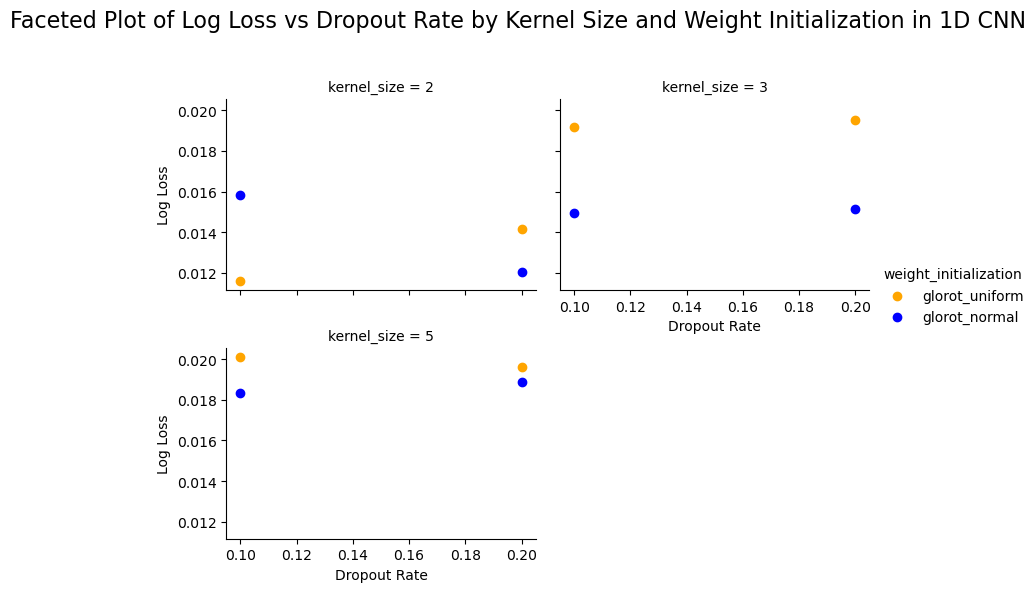

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = []
for model in list_of_trained_model_cnn:
    log_loss = model.loss
    data.append({
        'loss': log_loss,
        'kernel_size': model.params['kernel_size'],
        'dropout': model.params['drop_out'],
        'weight_initialization': model.params['init_mode']
    })

df = pd.DataFrame(data)
color_map = {'glorot_uniform': 'orange', 'glorot_normal': 'blue'}

g = sns.FacetGrid(df, col="kernel_size", hue='weight_initialization', palette=color_map, col_wrap=2)
g.map(plt.scatter, 'dropout', 'loss')  
g.add_legend()
g.set_axis_labels("Dropout Rate", "Log Loss")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Faceted Plot of Log Loss vs Dropout Rate by Kernel Size and Weight Initialization in 1D CNN', fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


### Model training with new hyperparameter

In [ ]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'kernel_size':2
}
windows=[8,12,16,20,24,28]
features=12
n_future = 1
rmse_scores = {}
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled , _ = preprocess_data(economic_war_data)
for window in windows:
    n_past=window
    (X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
    num_nodes=param_grid['num_nodes']
    learning_rate=param_grid['learning_rate']
    drop_out=param_grid['drop_out']
    init_mode=param_grid['init_mode']
    activation=param_grid['activation']
    optimizer=param_grid['optimizer']
    n_batch=param_grid['batch_size']
    kernel_size=param_grid['kernel_size']
    model_cnn=define_model_cnn(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, kernel_size=kernel_size, features = features,window=window)
    trained_model_cnn = train_model(model_cnn, X_train, y_train, n_batch, epochs=32)
    rmse_scores[window] = min(trained_model_cnn.history['val_root_mean_squared_error'])
input_size_cnn_df=pd.DataFrame(list(rmse_scores.items()), columns=['Window_Size_cnn', 'RMSE']) 

In [121]:
input_size_cnn_df.sort_values(by='RMSE')

,Window_Size_cnn,RMSE
3,20,0.027971
4,24,0.035556
1,12,0.039761
5,28,0.040284
0,8,0.041100
2,16,0.055353


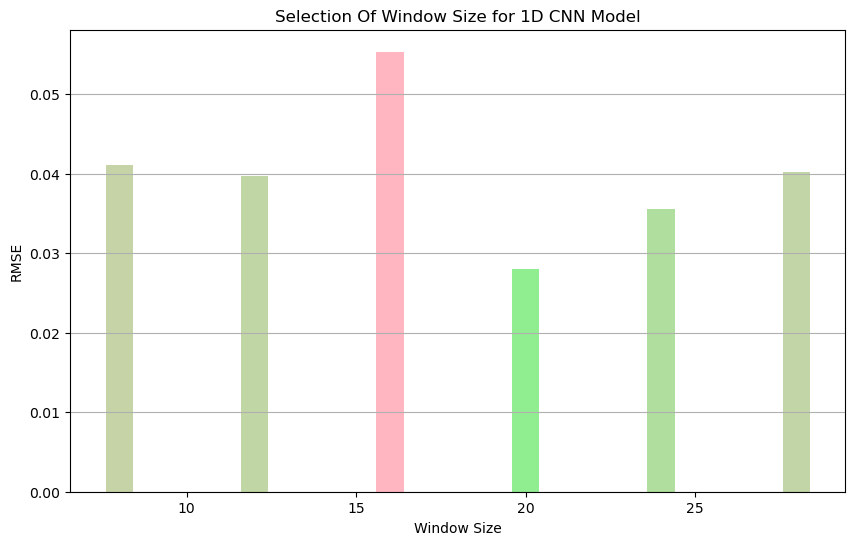

In [133]:
df_sorted = input_size_cnn_df.sort_values(by="RMSE")
def interpolate_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    light_green = np.array([144, 238, 144]) / 255.0
    light_red = np.array([255, 182, 193]) / 255.0
    color = light_green * (1 - normalized) + light_red * normalized

    return color

min_rmse = df_sorted['RMSE'].min()
max_rmse = df_sorted['RMSE'].max()
colors = [interpolate_color(value, min_rmse, max_rmse) for value in df_sorted['RMSE']]
plt.figure(figsize=(10, 6))
plt.bar(df_sorted["Window_Size_cnn"], df_sorted["RMSE"], color=colors)
plt.title("Selection Of Window Size for 1D CNN Model")
plt.xlabel("Window Size")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()



### CNN model training with all hyperparameter in place

param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'kernel_size':2
}
window=16
features=12
n_future = 1
n_past = window 
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled = preprocess_data(economic_war_data)
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
num_nodes=param_grid['num_nodes']
learning_rate=param_grid['learning_rate']
drop_out=param_grid['drop_out']
init_mode=param_grid['init_mode']
activation=param_grid['activation']
optimizer=param_grid['optimizer']
n_batch=param_grid['batch_size']
kernel_size=param_grid['kernel_size']
model_cnn=define_model_cnn(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer,kernel_size,window,features)
trained_model_cnn = train_model(model_cnn, X_train, y_train,n_batch,epochs=32)

In [82]:
cnn_train_df = pd.DataFrame({
    'CNN_TRAIN_MSE': trained_model_cnn.history['loss'],
    'CNN_TRAIN_RMSE': trained_model_cnn.history['root_mean_squared_error']
})

cnn_val_df = pd.DataFrame({
    'CNN_VAL_MSE': trained_model_cnn.history['val_loss'],
    'CNN_VAL_RMSE': trained_model_cnn.history['val_root_mean_squared_error']
})
concatenated_df_cnn = pd.concat([cnn_train_df, cnn_val_df], axis=1)
concatenated_df_cnn['epoch'] = range(0, len(concatenated_df_cnn))
concatenated_df_cnn

,CNN_TRAIN_MSE,CNN_TRAIN_RMSE,CNN_VAL_MSE,CNN_VAL_RMSE,epoch
0,0.281008,0.530101,0.069128,0.262922,0
1,0.073774,0.271614,0.013889,0.117853,1
2,0.051309,0.226514,0.013408,0.115792,2
3,0.055343,0.235251,0.009290,0.096385,3
4,0.039886,0.199715,0.012764,0.112979,4
...,...,...,...,...,...
95,0.002000,0.044727,0.001130,0.033617,95
96,0.001430,0.037811,0.001661,0.040759,96
97,0.001317,0.036289,0.004356,0.065999,97
98,0.001532,0.039137,0.003149,0.056113,98


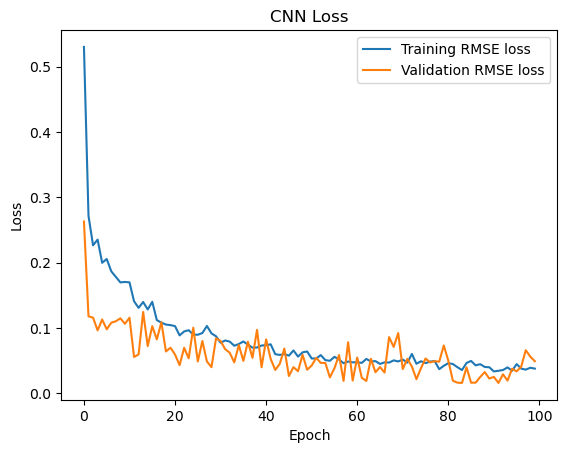

In [83]:
plt.plot(concatenated_df_cnn['epoch'], concatenated_df_cnn['CNN_TRAIN_RMSE'], label='Training RMSE loss')
plt.plot(concatenated_df_cnn['epoch'], concatenated_df_cnn['CNN_VAL_RMSE'], label='Validation RMSE loss')
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc='upper right')
plt.show()

### GRU

In [ ]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
window=16
features=12
n_future = 1
n_past = window 
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled = preprocess_data(economic_war_data)
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
num_nodes=param_grid['num_nodes']
learning_rate=param_grid['learning_rate']
drop_out=param_grid['drop_out']
init_mode=param_grid['init_mode']
activation=param_grid['activation']
optimizer=param_grid['optimizer']
n_batch=param_grid['batch_size']
model_gru=define_model_gru(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer,window,features)
trained_model_gru = train_model(model_gru, X_train, y_train,n_batch,epochs=28)

In [70]:
gru_train_df = pd.DataFrame({
    'GRU_TRAIN_MSE': trained_model_gru.history['loss'],
    'GRU_TRAIN_RMSE': trained_model_gru.history['root_mean_squared_error']
})
gru_val_df = pd.DataFrame({
    'GRU_VAL_MSE': trained_model_gru.history['val_loss'],
    'GRU_VAL_RMSE': trained_model_gru.history['val_root_mean_squared_error']
})
concatenated_df_gru = pd.concat([gru_train_df, gru_val_df], axis=1)
concatenated_df_gru['epoch'] = range(0, len(concatenated_df_gru))
concatenated_df_gru

,GRU_TRAIN_MSE,GRU_TRAIN_RMSE,GRU_VAL_MSE,GRU_VAL_RMSE,epoch
0,0.171963,0.414685,0.040516,0.201286,0
1,0.036094,0.189985,0.020814,0.144272,1
2,0.028258,0.168101,0.004307,0.065626,2
3,0.025138,0.158549,0.006626,0.081398,3
4,0.020109,0.141807,0.005306,0.072841,4
...,...,...,...,...,...
95,0.003682,0.060682,0.000636,0.025219,95
96,0.003631,0.060257,0.001838,0.042866,96
97,0.004069,0.063788,0.000705,0.026547,97
98,0.004800,0.069281,0.000573,0.023948,98


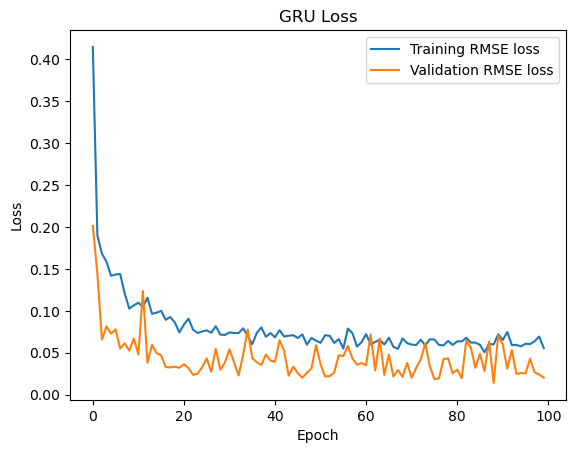

In [71]:
plt.plot(concatenated_df_gru['epoch'], concatenated_df_gru['GRU_TRAIN_RMSE'], label='Training RMSE loss')
plt.plot(concatenated_df_gru['epoch'], concatenated_df_gru['GRU_VAL_RMSE'], label='Validation RMSE loss')
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc='upper right')
plt.show()

### Model Comparison Based On Validation RMSE

In [84]:
merged_df = pd.merge(concatenated_df, concatenated_df_cnn, on='epoch', how='left', suffixes=('', '_cnn'))
final_merged_df = pd.merge(merged_df, concatenated_df_gru, on='epoch', how='left', suffixes=('', '_gru'))
final_merged_df=final_merged_df[['epoch','LSTM_VAL_RMSE','CNN_VAL_RMSE','GRU_VAL_RMSE']]
final_merged_df

,epoch,LSTM_VAL_RMSE,CNN_VAL_RMSE,GRU_VAL_RMSE
0,0,0.142011,0.262922,0.201286
1,1,0.062331,0.117853,0.144272
2,2,0.056901,0.115792,0.065626
3,3,0.114129,0.096385,0.081398
4,4,0.083303,0.112979,0.072841
...,...,...,...,...
95,95,0.050874,0.033617,0.025219
96,96,0.037604,0.040759,0.042866
97,97,0.028033,0.065999,0.026547
98,98,0.039857,0.056113,0.023948


In [85]:
lstm_rmse=final_merged_df['LSTM_VAL_RMSE'].mean()
gru_rmse=final_merged_df['GRU_VAL_RMSE'].mean()
cnn_rmse=final_merged_df['CNN_VAL_RMSE'].mean()

In [86]:
lstm_rmse

0.053016744833439586

In [87]:
gru_rmse

0.04397061627358198

In [88]:
cnn_rmse

0.05879043290391564

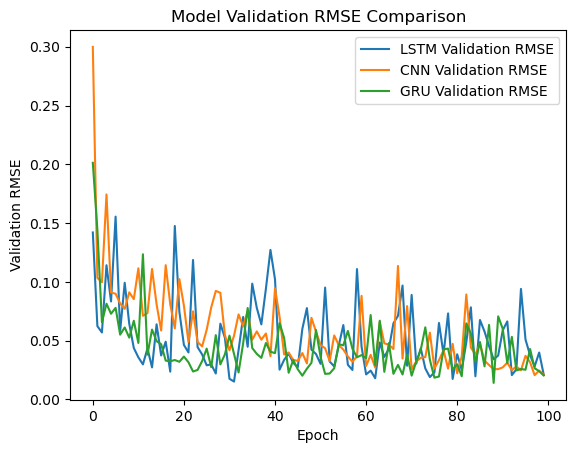

In [73]:
plt.plot(final_merged_df['epoch'], final_merged_df['LSTM_VAL_RMSE'], label='LSTM Validation RMSE')
plt.plot(final_merged_df['epoch'], final_merged_df['CNN_VAL_RMSE'], label='CNN Validation RMSE')
plt.plot(final_merged_df['epoch'], final_merged_df['GRU_VAL_RMSE'], label='GRU Validation RMSE')

plt.title('Model Validation RMSE Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation RMSE')
plt.legend()
plt.show()

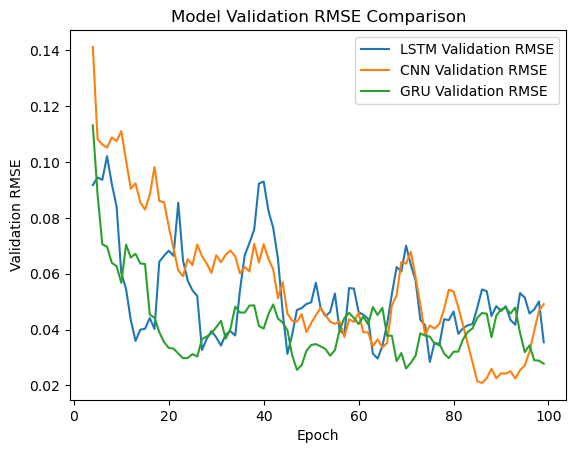

In [89]:
rolling_mean_df = final_merged_df.set_index('epoch').rolling(window=5).mean()
plt.plot(rolling_mean_df['LSTM_VAL_RMSE'], label='LSTM Validation RMSE')
plt.plot(rolling_mean_df['CNN_VAL_RMSE'], label='CNN Validation RMSE')
plt.plot(rolling_mean_df['GRU_VAL_RMSE'], label='GRU Validation RMSE')

plt.title('Model Validation RMSE Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation RMSE')
plt.legend()
plt.show()